In [1]:
import pandas as pd
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# Load the data
df = pd.read_csv("student_dataset.csv")

# Normalize numerical features for similarity calculation
scaler = MinMaxScaler()
numerical_features = df[["SES", "achievement", "psychological_distress"]]
normalized_features = scaler.fit_transform(numerical_features)

# Encode categorical features manually
df['gender_code'] = df['gender'].map({'male': 0, 'female': 1})
df['immigrant_code'] = df['immigrant_status'].map({'non-immigrant': 0, '1st-gen': 1, '2nd-gen': 2})

# Combine all features
combined_features = pd.concat([
    pd.DataFrame(normalized_features),
    df[["gender_code", "immigrant_code"]]
], axis=1)

# Compute similarity matrix
similarity_matrix = cosine_similarity(combined_features)

# Create graph
G = nx.Graph()

# Add nodes with attributes
for _, row in df.iterrows():
    G.add_node(row["student_id"], gender=row["gender"], SES=row["SES"],
               achievement=row["achievement"], distress=row["psychological_distress"],
               immigrant_status=row["immigrant_status"])

# Add edges based on similarity threshold
threshold = 0.85  # You can adjust this
for i in range(len(df)):
    for j in range(i+1, len(df)):
        sim = similarity_matrix[i][j]
        if sim >= threshold:
            G.add_edge(df.loc[i, "student_id"], df.loc[j, "student_id"], weight=sim)

# Print summary
print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


Graph created with 1000 nodes and 102204 edges


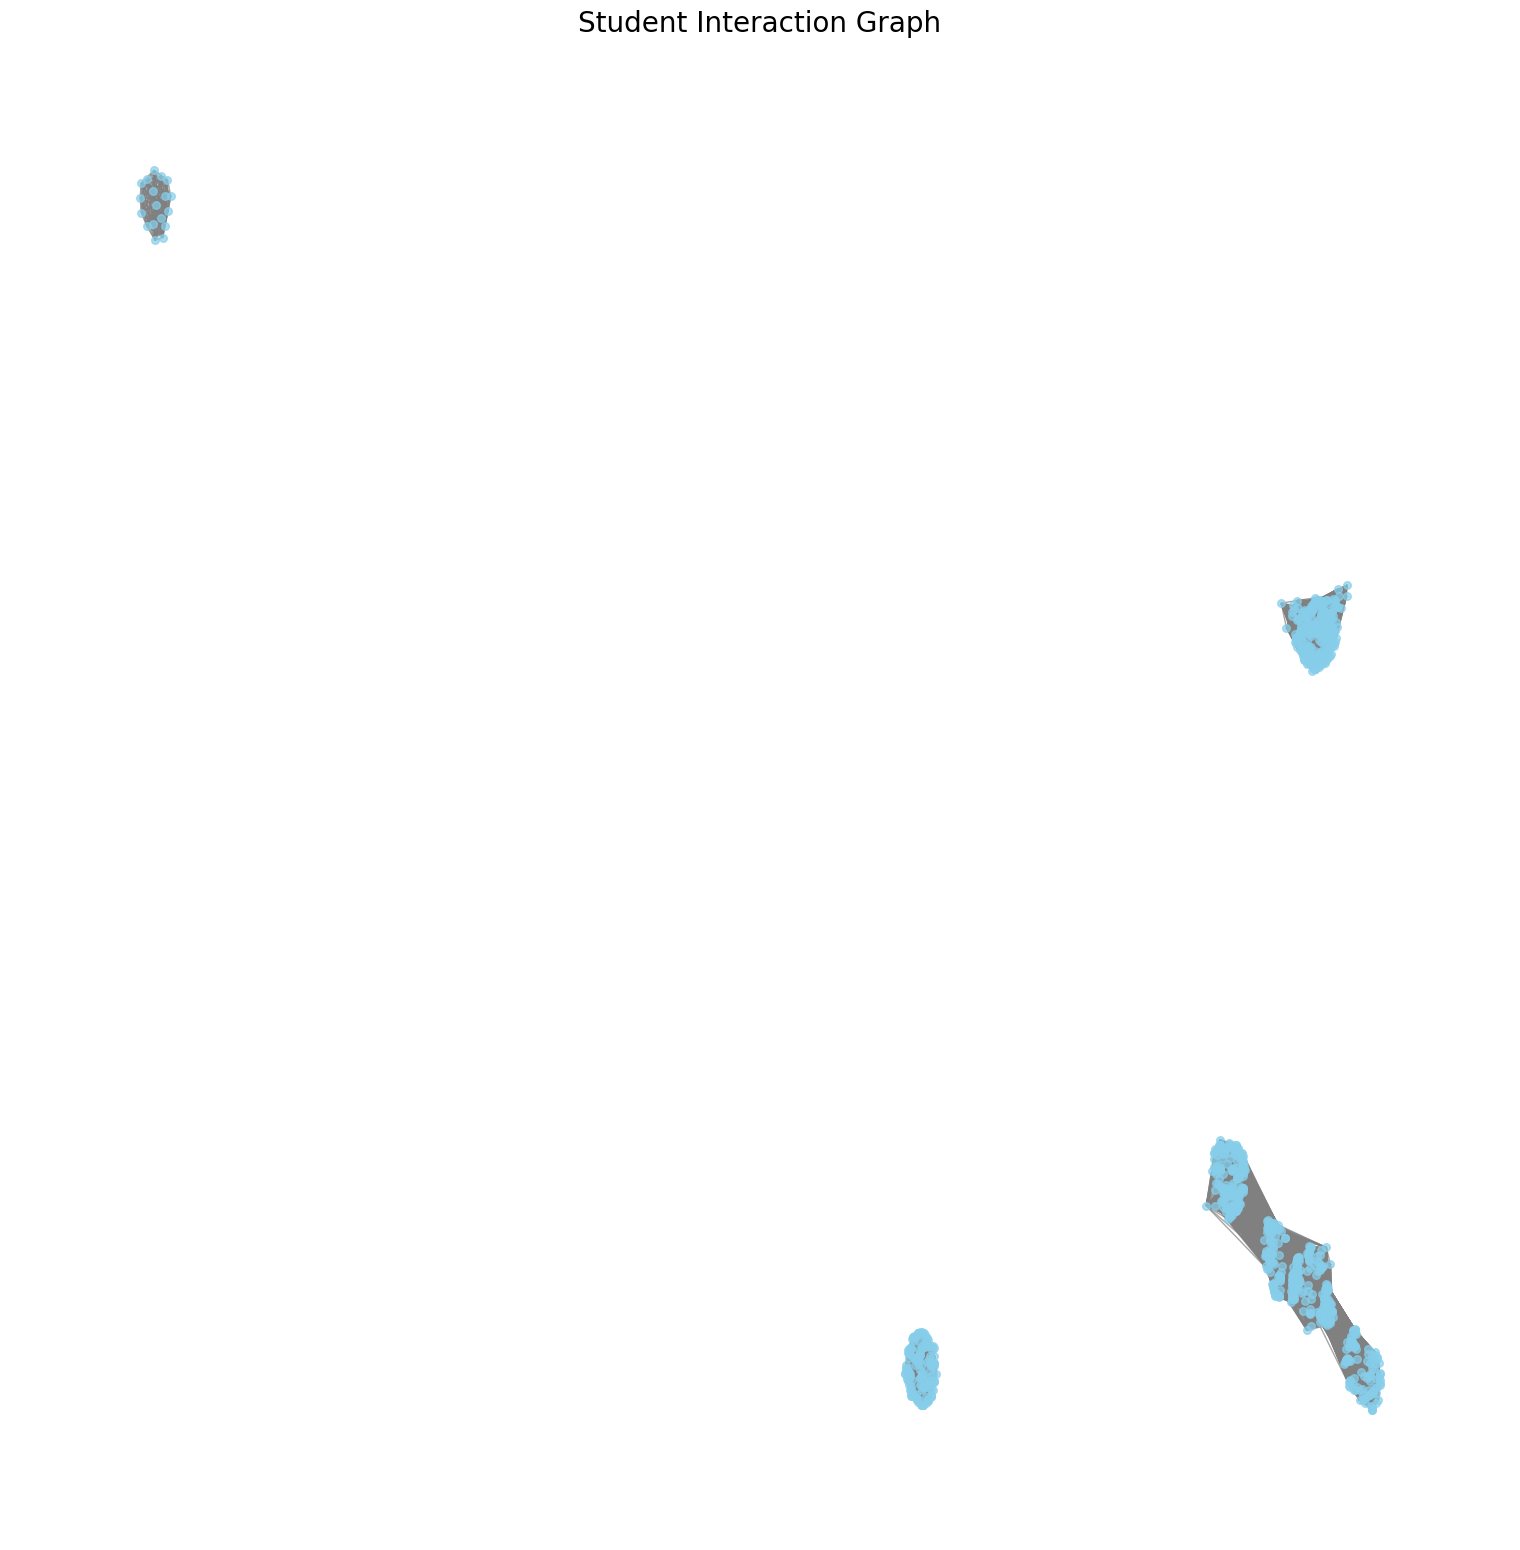

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))  # width x height
pos = nx.spring_layout(G, seed=42)  # you can adjust the layout algorithm
nx.draw(G, pos, 
        node_size=30, 
        node_color="skyblue", 
        edge_color="gray", 
        with_labels=False, 
        alpha=0.7)
plt.title("Student Interaction Graph", fontsize=20)
plt.show()


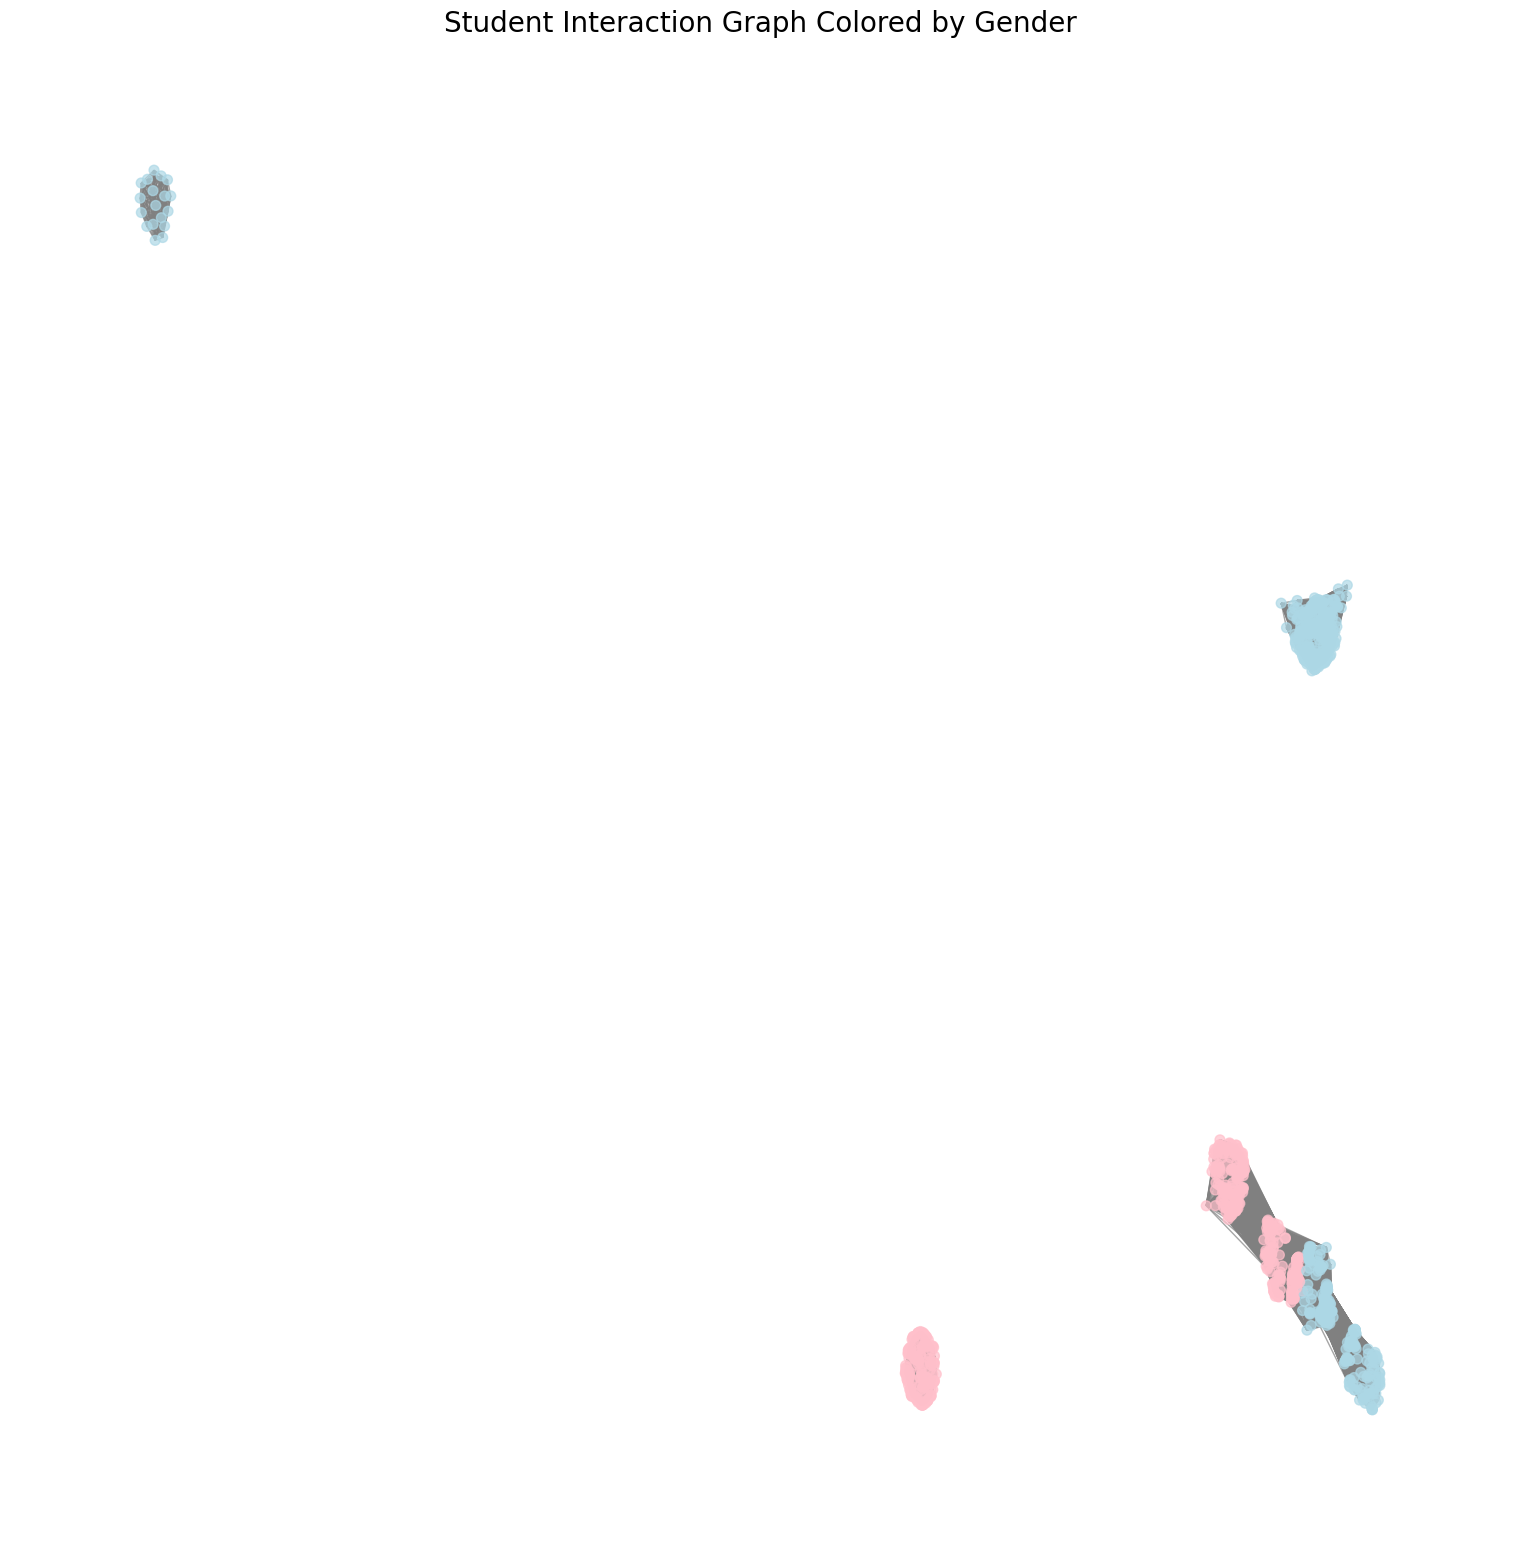

In [3]:
# Color nodes by gender
color_map = []
for node in G.nodes(data=True):
    if node[1]['gender'] == 'male':
        color_map.append('lightblue')
    else:
        color_map.append('pink')

plt.figure(figsize=(15, 15))
nx.draw(G, pos, 
        node_color=color_map, 
        node_size=50, 
        edge_color="gray", 
        with_labels=False,
        alpha=0.7)
plt.title("Student Interaction Graph Colored by Gender", fontsize=20)
plt.show()

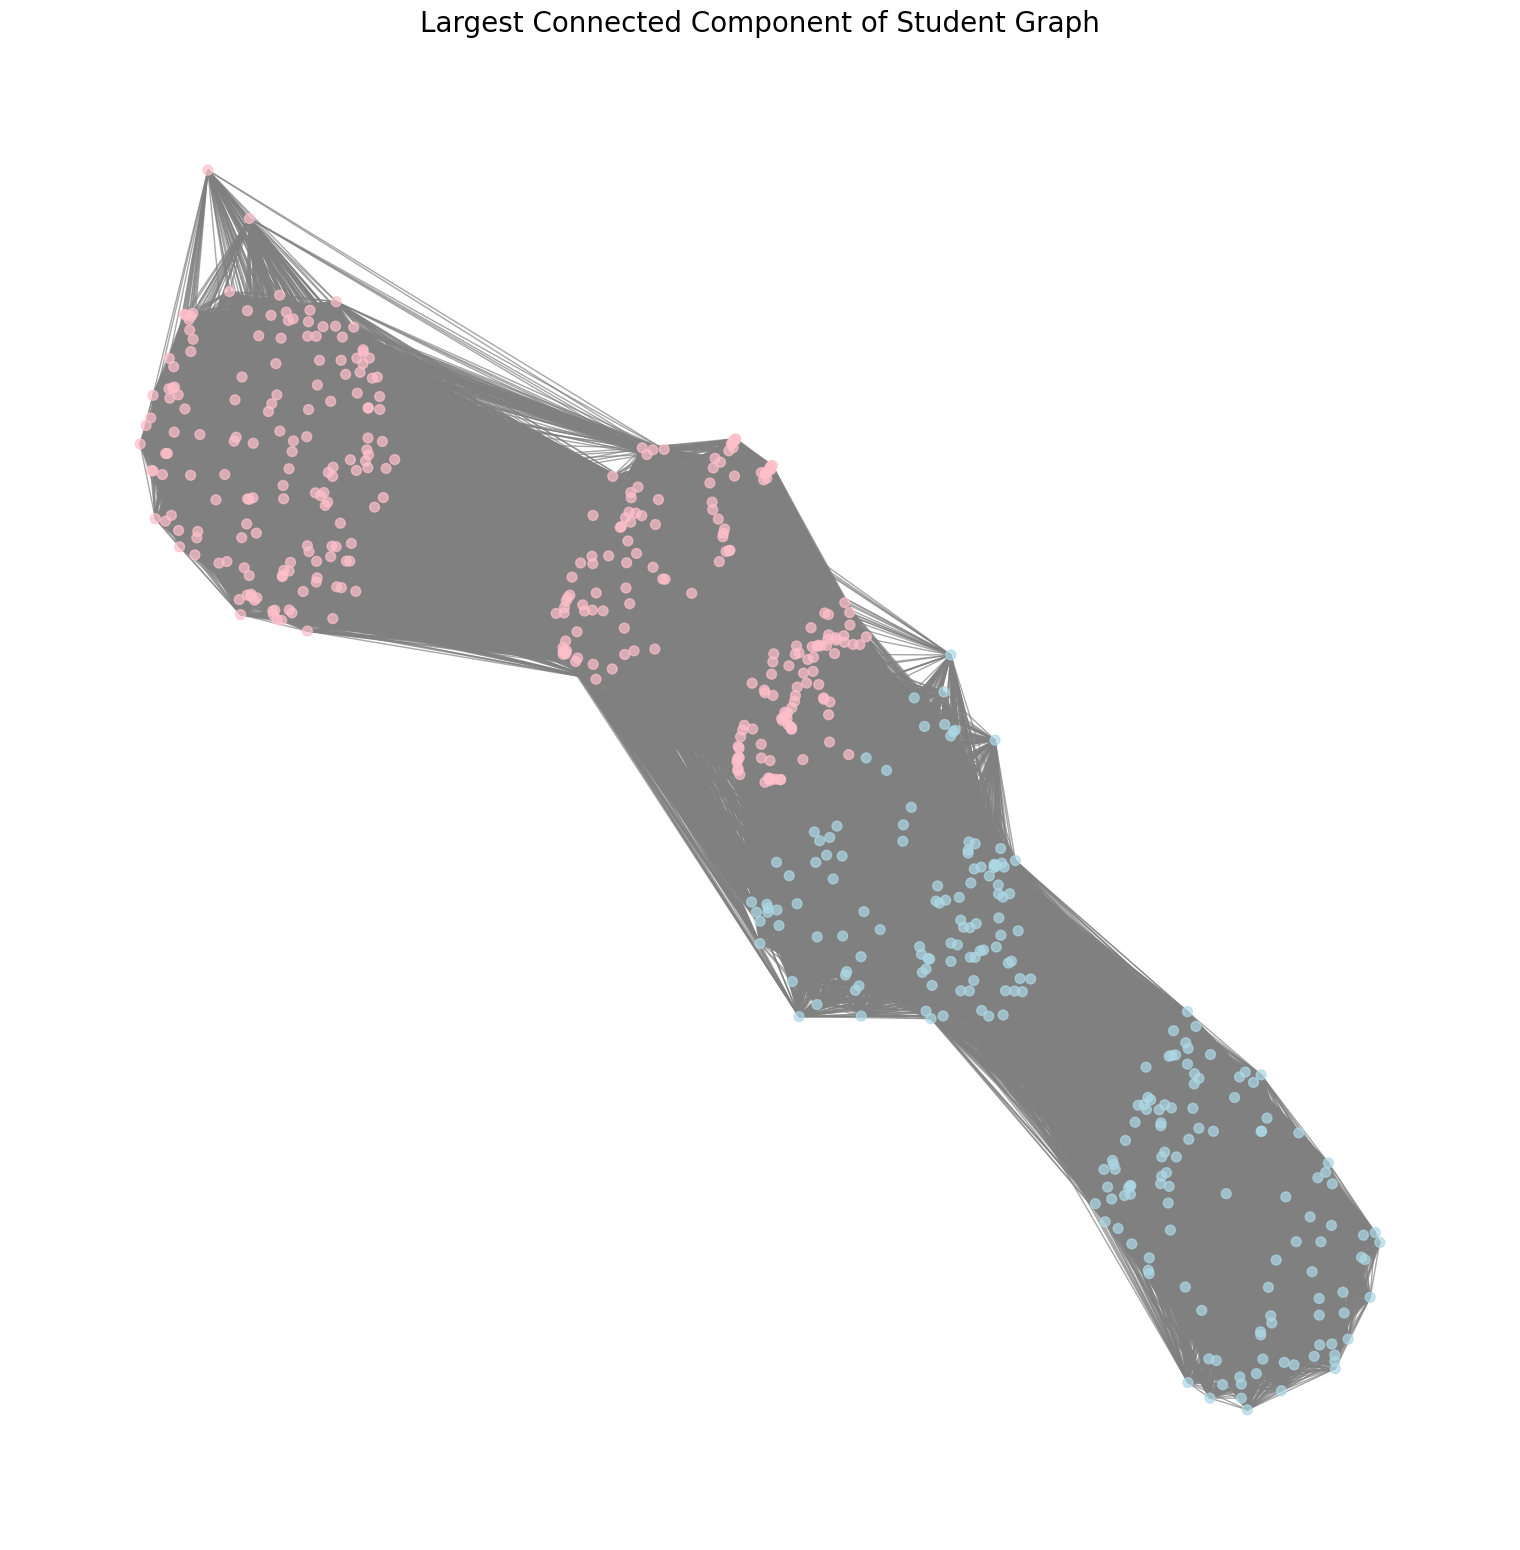

In [4]:
# 1. Create largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G_subgraph = G.subgraph(largest_cc).copy()

# 2. Create a color map ONLY for nodes in G_subgraph
color_map_subgraph = []
for node in G_subgraph.nodes(data=True):
    if node[1]['gender'] == 'male':
        color_map_subgraph.append('lightblue')
    else:
        color_map_subgraph.append('pink')

# 3. Plot the subgraph
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G_subgraph, seed=42)
nx.draw(G_subgraph, pos, 
        node_size=50, 
        node_color=color_map_subgraph, 
        edge_color="gray", 
        with_labels=False, 
        alpha=0.7)
plt.title("Largest Connected Component of Student Graph", fontsize=20)
plt.show()


In [5]:
# 1. Node Degree
degree_dict = dict(G.degree())

# 2. Clustering Coefficient
clustering_dict = nx.clustering(G)

# 3. Average SES of neighbors
avg_neighbor_ses = {}
for node in G.nodes:
    neighbors = list(G.neighbors(node))
    if neighbors:
        ses_values = [G.nodes[neighbor].get('SES', 0) for neighbor in neighbors]
        avg_neighbor_ses[node] = sum(ses_values) / len(ses_values)
    else:
        avg_neighbor_ses[node] = None

# 4. Average Psychological Distress of neighbors
avg_neighbor_distress = {}
for node in G.nodes:
    neighbors = list(G.neighbors(node))
    if neighbors:
        distress_values = [G.nodes[neighbor].get('psychological_distress', 0) for neighbor in neighbors]
        avg_neighbor_distress[node] = sum(distress_values) / len(distress_values)
    else:
        avg_neighbor_distress[node] = None

# 5. Compile into DataFrame
features_df = pd.DataFrame({
    'student_id': list(G.nodes),
    'degree': [degree_dict[n] for n in G.nodes],
    'clustering_coefficient': [clustering_dict[n] for n in G.nodes],
    'avg_neighbor_ses': [avg_neighbor_ses[n] for n in G.nodes],
    'avg_neighbor_distress': [avg_neighbor_distress[n] for n in G.nodes]
})

# Show first few rows
print(features_df.head())


   student_id  degree  clustering_coefficient  avg_neighbor_ses  \
0           1     145                1.000000          5.917931   
1           2     145                1.000000          5.910345   
2           3     261                0.941055          5.344061   
3           4     240                0.679533          4.671667   
4           5     185                0.862867          3.967568   

   avg_neighbor_distress  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0  


In [6]:
import os

# Create folder if it doesn't exist
os.makedirs("graph_outputs", exist_ok=True)

# Save features to CSV
features_df.to_csv("graph_outputs/student_graph_features.csv", index=False)



## Step 4: Centrality Measures for Influencer Detection
In this step, we compute important centrality measures (Degree Centrality and Betweenness Centrality) for each student node to detect potential influencers in the student graph.


In [7]:
# Step 4: Compute Centrality Measures

import networkx as nx
import pandas as pd

# 1. Compute Degree Centrality
degree_centrality = nx.degree_centrality(G)
print("Degree Centrality calculated.")

# 2. Compute Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)
print("Betweenness Centrality calculated.")

# 3. Attach Centrality Attributes to Graph Nodes
nx.set_node_attributes(G, degree_centrality, "degree_centrality")
nx.set_node_attributes(G, betweenness_centrality, "betweenness_centrality")
print("Centrality attributes added to graph nodes.")

# 4. Create a DataFrame for Centrality Measures
centrality_df = pd.DataFrame({
    'student_id': list(degree_centrality.keys()),
    'degree_centrality': list(degree_centrality.values()),
    'betweenness_centrality': list(betweenness_centrality.values())
})

# Show first few rows
centrality_df.head()


Degree Centrality calculated.
Betweenness Centrality calculated.
Centrality attributes added to graph nodes.


,student_id,degree_centrality,betweenness_centrality
0,1,0.145145,0.000000
1,2,0.145145,0.000000
2,3,0.261261,0.000027
3,4,0.240240,0.001587
4,5,0.185185,0.000202


### Saving Centrality Measures
We save the centrality measures into a CSV file inside the `graph_outputs` folder for future use (e.g., GAT seeding).


In [8]:
# Make sure output folder exists
import os
os.makedirs("graph_outputs", exist_ok=True)

# Save Centrality Measures
centrality_df.to_csv("graph_outputs/student_centrality_measures.csv", index=False)
print("Centrality measures saved to graph_outputs/student_centrality_measures.csv")


Centrality measures saved to graph_outputs/student_centrality_measures.csv


In [9]:
# Save your graph
nx.write_graphml(G, "student_graph.graphml")
